In [1]:
# used to handle data
import pandas as pd

# used to handle geo data
from shapely.ops import transform, Point
from geopandas.tools import reverse_geocode
import geopandas as gpd

# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot as plt

import folium

from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors

# tells matplotlib to embed plots within the notebook
%matplotlib inline

read data

In [2]:
NYU_POIs = gpd.read_file('NYC_POIs.shp')
NYU_POIs = gpd.GeoDataFrame(NYU_POIs,crs={'init': 'epsg:4326'})
flickr = pd.read_csv('flickr_output.txt')


adding to flickr geometry column and turn into gdf

In [3]:
# creating list of x,y objects to turn into points
flickr['point'] = list(zip(flickr.X, flickr.Y))
flickr.head()

# creating geometry column from shapley points
flickr['geometry'] = flickr['point'].apply(Point)
flickr.head()

,X,Y,URL,Day,Month,Year,Date,User,Likes,Acc_level,FID,point,geometry
0,-73.982978,40.766672,https://www.flickr.com/photos/26946559@N02/489...,19,10,2019,19/10/2019 12:56:43,26946559@N02,0,Street,1,"(-73.982978, 40.766672)",POINT (-73.982978 40.766672)
1,-73.982978,40.766672,https://www.flickr.com/photos/26946559@N02/489...,19,10,2019,19/10/2019 12:54:59,26946559@N02,1,Street,2,"(-73.982978, 40.766672)",POINT (-73.982978 40.766672)
2,-73.982978,40.766672,https://www.flickr.com/photos/26946559@N02/489...,19,10,2019,19/10/2019 12:53:53,26946559@N02,0,Street,3,"(-73.982978, 40.766672)",POINT (-73.982978 40.766672)
3,-73.982978,40.766672,https://www.flickr.com/photos/26946559@N02/489...,19,10,2019,19/10/2019 12:51:42,26946559@N02,1,Street,4,"(-73.982978, 40.766672)",POINT (-73.982978 40.766672)
4,-73.982978,40.766672,https://www.flickr.com/photos/26946559@N02/489...,19,10,2019,19/10/2019 12:55:56,26946559@N02,1,Street,5,"(-73.982978, 40.766672)",POINT (-73.982978 40.766672)


In [4]:
# 'point' column is no longer needed
flickr = flickr.drop('point',1)
# turn the data frame into geodataframe
flickr = gpd.GeoDataFrame(flickr, geometry='geometry', crs={'init': 'epsg:4326'})

sanity check

<function matplotlib.pyplot.show(*args, **kw)>

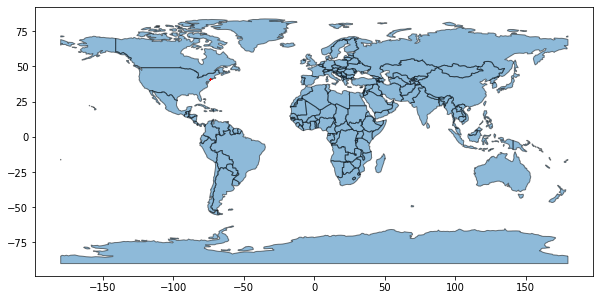

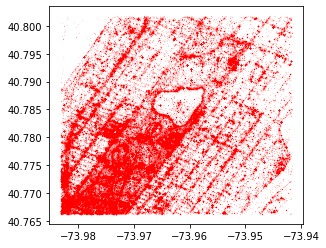

In [6]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

flickr.plot(ax=ax,color='red',alpha=0.5, markersize=0.1)
plt.show

flickr.plot(color='red',alpha=0.5, markersize=0.01)
plt.show

we digitized central park boundaries in qgis and exported to shp

In [5]:
central_park_polygon = gpd.read_file('central_park_polygon.shp')


sanity check

<function matplotlib.pyplot.show(*args, **kw)>

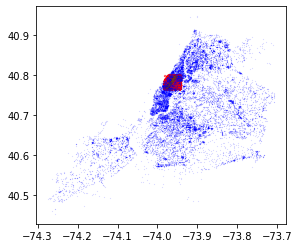

In [8]:
ax = flickr.plot(color='red',alpha=0.5, markersize=0.01)
plt.show
central_park_polygon.plot(ax=ax,color='green',alpha=0.5, markersize=0.01)
plt.show
NYU_POIs.plot(ax=ax,color='blue',alpha=0.5, markersize=0.01)
plt.show

getting only the points inside central park

In [6]:
pip = NYU_POIs.within((central_park_polygon.loc[0,'geometry']))
NYU_POIs = NYU_POIs.loc[pip]
pip = flickr.within((central_park_polygon.loc[0,'geometry']))
flickr = flickr.loc[pip]

check filter results

<function matplotlib.pyplot.show(*args, **kw)>

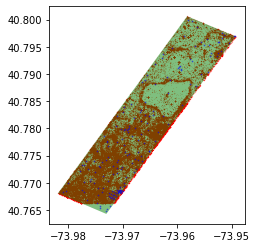

In [10]:
ax = flickr.plot(color='red',alpha=0.5, markersize=0.01)
plt.show
central_park_polygon.plot(ax=ax,color='green',alpha=0.5, markersize=0.01)
plt.show
NYU_POIs.plot(ax=ax,color='blue',alpha=0.5, markersize=0.5)
plt.show

Clustering

we sample randomly 1% from the flickr data to make clustering faster

In [11]:
flickr_small = flickr.sample(frac = 0.01)

# NYU_POIs = NYU_POIs.to_crs({'init': 'epsg:32116'})
flickr_small = flickr_small.to_crs({'init': 'epsg:32116'})
flickr_small['X'] = flickr_small.geometry.values.x
flickr_small['Y'] = flickr_small.geometry.values.y

### cluster with Kmeans

finding optimal number of cluster using the knee method

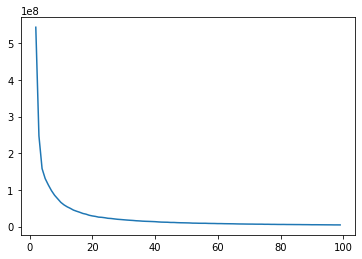

In [12]:
ssd = []
for i in range(2, 100):
    km = KMeans(n_clusters=i)
    km.fit_predict(flickr_small[['X','Y']])
    ssd.append(km.inertia_)


plt.plot(range(2,100), ssd)
plt.show()

knee is in about k=15

<Figure size 864x576 with 0 Axes>

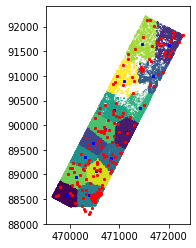

In [39]:
km = KMeans(n_clusters=15)
km.fit_predict(flickr[['X','Y']])

flickr['cluster'] = km.labels_
plt.figure(figsize=(12,8))
ax = flickr.plot(c=km.labels_, markersize=0.1)

plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='blue',marker= 'X', s=5)
NYU_POIs.plot(ax=ax,color='red',marker= 'x', markersize=5)
plt.show()

it seems that the result not really reflect the POI's
so we draw also kmeans of 100 clusters

<Figure size 864x576 with 0 Axes>

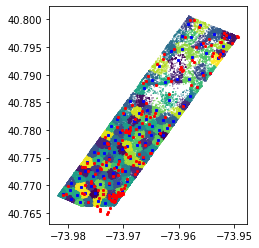

In [13]:

km = KMeans(n_clusters=100)
km.fit_predict(flickr[['X','Y']])

flickr['cluster'] = km.labels_
plt.figure(figsize=(12,8))
ax = flickr.plot(c=km.labels_, markersize=0.1)

plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='blue',marker= 'X', s=5)
NYU_POIs.plot(ax=ax,color='red',marker= 'x', markersize=5)
plt.show()

### cluster with DBscan

finding optimal number of cluster using the knee method on nearest neighbors average distance

In [7]:
flickr_small =flickr.sample(frac = 0.20)
flickr_small = flickr_small.to_crs({'init': 'epsg:32116'})
flickr_small['X'] = flickr_small.geometry.values.x
flickr_small['Y'] = flickr_small.geometry.values.y


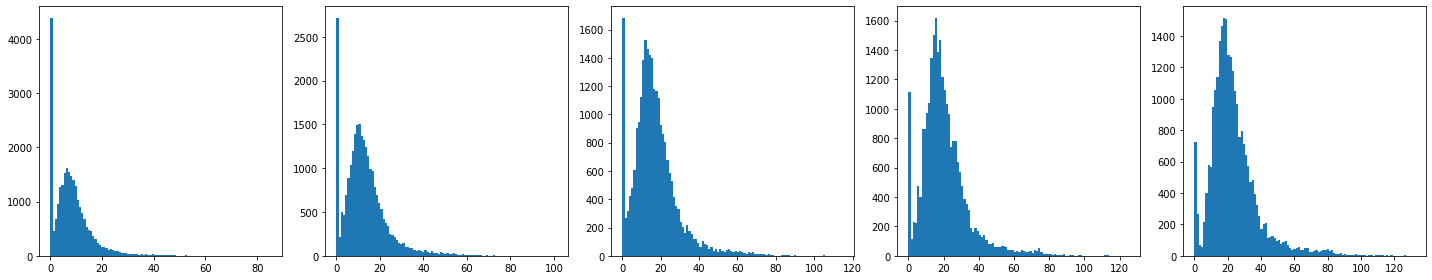

In [8]:
k = [10, 20, 30, 40, 50]
fig, axs = plt.subplots(nrows=1, ncols=5,sharey=True, figsize=(20,4))
c=1

for i in range(5):
    plt.subplot(1,5,c)
    nbrs = NearestNeighbors(n_neighbors=k[i], algorithm='ball_tree').fit(flickr_small[['X','Y']])
    distances, indices = nbrs.kneighbors(flickr_small[['X','Y']])
    avg_k_nearest_distances = np.average(distances,1)
    plt.hist(avg_k_nearest_distances,100)
    # axs[i] = plt.hist(avg_k_nearest_distances,100)
    c = c+1
fig.tight_layout()

In [12]:
NYU_POIs = NYU_POIs.to_crs({'init': 'epsg:32116'})

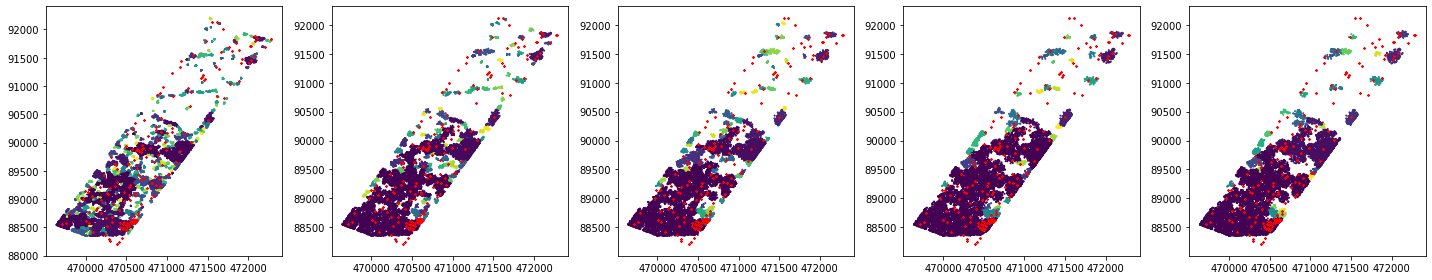

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=5,sharey=True, figsize=(20,4))
eps = [17, 25, 30, 37, 40]
c=1
num_of_clusters = []
for i in range(5):
    plt.subplot(1,5,c)
    db = DBSCAN(eps = eps[i], min_samples = k[i]).fit(flickr_small[['X','Y']].values)
    flickr_small['label'] = db.labels_
    # remove the points labeled as noise from the result
    not_noise_indices = flickr_small['label']!=-1
    flickr_small_without_noise = flickr_small[not_noise_indices]
    num_of_clusters.append(max(flickr_small_without_noise['label']))
    # plot result
    plt.scatter(flickr_small_without_noise['X'],flickr_small_without_noise['Y'], c=flickr_small_without_noise['label'], s=1)
    plt.scatter(NYU_POIs.geometry.values.x,NYU_POIs.geometry.values.y,s=3,c='red',marker='x')
    c = c+1

fig.tight_layout()

In [21]:
fig.savefig('dbscan_results.png')

In [20]:
print('number of clusters for each set of parameters are:')
for i in range(5):
    print('for eps= ',eps[i],'and k= ',k[i],' number of clusters is: ',num_of_clusters[i])

number of clusters for each set of parameters are:
for eps=  17 and k=  10  number of clusters is:  265
for eps=  25 and k=  20  number of clusters is:  98
for eps=  30 and k=  30  number of clusters is:  59
for eps=  37 and k=  40  number of clusters is:  33
for eps=  40 and k=  50  number of clusters is:  29


We can see that with the first set of parameters we got
results that are pretty close to the POI layer.

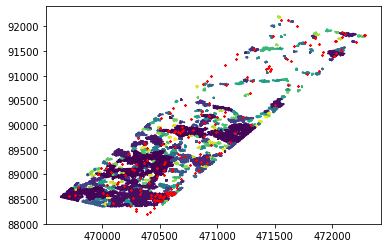

In [79]:
db = DBSCAN(eps = eps[0], min_samples = k[0]).fit(flickr_small[['X','Y']].values)
flickr_small['label'] = db.labels_
# remove the points labeled as noise from the result
not_noise_indices = flickr_small['label']!=-1
flickr_small_without_noise = flickr_small[not_noise_indices]
num_of_clusters.append(max(flickr_small_without_noise['label']))
# plot result
plt.scatter(flickr_small_without_noise['X'],flickr_small_without_noise['Y'], c=flickr_small_without_noise['label'], s=1)
plt.scatter(NYU_POIs.geometry.values.x,NYU_POIs.geometry.values.y,s=3,c='red',marker='x')

plt.show()

There are 265 clusters from the dbscan and 174 points in the POI layer
so there is still a big difference. for example we can see a dense group of POI's
in the bottom right corner that sit on one dbscan cluster. around the lake we
can see a lot of clusters that doesn't have a POI around them.

It seems that one problem that effect the dbscan is that there is too much data.
A lot of data comes with a lot of noise. the locations of the poi's get less specific.
We try to filter the data to only one year. We chose 2011.

In [34]:
flickr_2011 = flickr[flickr['Year']==2011]

C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


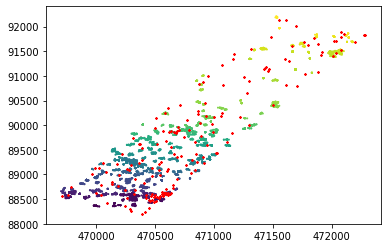

In [36]:
fig = plt.figure()
db = DBSCAN(eps = eps[0], min_samples = k[0]).fit(flickr_2011[['X','Y']].values)
flickr_2011['label'] = db.labels_
# remove the points labeled as noise from the result
not_noise_indices = flickr_2011['label']!=-1
flickr_2011_without_noise = flickr_2011[not_noise_indices]
num_of_clusters.append(max(flickr_2011_without_noise['label']))
# plot result
plt.scatter(flickr_2011_without_noise['X'],flickr_2011_without_noise['Y'], c=flickr_2011_without_noise['label'], s=1)
plt.scatter(NYU_POIs.geometry.values.x,NYU_POIs.geometry.values.y,s=3,c='red',marker='x')

plt.show()

In [37]:
fig.savefig('dbscan_2011')

Now the result of the dbscan seems a lot less noisy.
we got 205 clusters and each cluster seems more distinct.

In [38]:
flickr_2011.describe()

,X,Y,Day,Month,Year,Likes,FID,label
count,12253.000000,12253.000000,12253.000000,12253.000000,12253.0,12253.000000,12253.000000,12253.000000
mean,470667.392445,89603.272152,15.457521,6.591447,2011.0,1.025953,114040.258957,58.656084
std,568.652833,940.174885,8.802477,3.281329,0.0,20.047075,71820.338627,64.621829
min,469672.155330,88349.711968,1.000000,1.000000,2011.0,0.000000,1605.000000,-1.000000
25%,470266.596319,88879.306886,8.000000,4.000000,2011.0,0.000000,54598.000000,-1.000000
50%,470553.480646,89312.350951,16.000000,6.000000,2011.0,0.000000,98648.000000,40.000000
75%,470930.806673,90072.597268,23.000000,10.000000,2011.0,0.000000,172738.000000,103.000000
max,472290.294756,92210.109111,31.000000,12.000000,2011.0,1830.000000,256445.000000,205.000000


find the 5 most popular locations

In [80]:
index = np.arange(265)
popularity = []

In [81]:
for i in range (265):
    popularity.append(db.labels_[db.labels_== i].size)

popularity = np.vstack([index,np.asarray(popularity)]).T

In [82]:
popularity = popularity[np.argsort(popularity[:,1])]
popularity = popularity[::-1]
print(popularity[:5])

[[   0 3463]
 [  10 2896]
 [   4 1775]
 [   3 1431]
 [   2  919]]


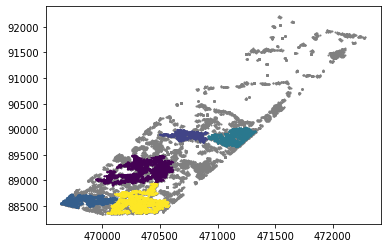

In [83]:
flickr_small_most_popular= flickr_small_without_noise[flickr_small_without_noise.label.isin(popularity[:5,0])]
plt.scatter(flickr_small_without_noise['X'],flickr_small_without_noise['Y'], c='gray', s=1)
plt.scatter(flickr_small_most_popular['X'],flickr_small_most_popular['Y'], c=flickr_small_most_popular['label'], s=1)